In [1]:
import gc
import pickle
import os
import torch

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from modules.experiment_config import get_seeds, get_targets
from modules.load_data import return_loaded_model, load_pickle, get_pickle_file_path, get_pickle_folder
from matplotlib.colors import ListedColormap
from numpy import interp
from seaborn import heatmap
from sklearn.metrics import roc_curve, accuracy_score, roc_auc_score, precision_recall_curve, auc, classification_report, confusion_matrix
from scipy.stats import kurtosis
from main import get_percentages

%matplotlib inline

In [2]:
targets = get_targets()
target_indices = list(range(len(targets)))
target_indices.append(None)
mimic_version = 4
time_step_id = 14
seeds = get_seeds()
seeds = [0]
n_folds = 3


debug = False
save_unimportant_figures = False

figure_format = 'png'
figure_dir = f'./output/figures/mimic_{mimic_version}'

if not os.path.exists(figure_dir):
    os.makedirs(figure_dir)

print(torch.cuda.current_device())
print(torch.cuda.device(0))
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))
print(torch.cuda.is_available())
print(f'{figure_dir=}')

0
1
NVIDIA GeForce RTX 2060
True
figure_dir='./output/figures/mimic_4'


## Data Exploration

In [3]:
if targets == 'MI':
    my_cmap = ListedColormap(sns.color_palette("Reds", 150))
    color_list = sns.color_palette("Reds", 14)
    color_list_reduced = sns.color_palette("Reds", 7) 
elif targets == 'SEPSIS':
    my_cmap = sns.cubehelix_palette(14, start=2, rot=0, dark=0.25, light=.95, as_cmap=True)
    color_list = sns.cubehelix_palette(14, start=2, rot=0, dark=0.15, light=.8)
    color_list_reduced = sns.cubehelix_palette(7, start=2, rot=0, dark=0.15, light=.8)
else:
    my_cmap= sns.cubehelix_palette(14, as_cmap=True)
    color_list = sns.cubehelix_palette(14)
    color_list_reduced = sns.cubehelix_palette(7)

In [4]:
## PICKLE LOADS
def load_pickle_file(file_name, target, folder):
    return load_pickle(get_pickle_file_path(file_name, target, folder))

def get_model_name(model_type, mimic_version, target, time_step_id, seed, fold=None):
    model_name = f'{model_type}_{mimic_version}_{target}_{time_step_id}_{seed}'
    if fold is not None:
        model_name += f'_{fold}'
    return model_name

def load_model(model_name):
    return return_loaded_model(model_name).cpu()

def get_model_dict(model_type, mimic_version, target, time_step_id, seeds, n_folds):
    model_dict = dict()

    for model_type in model_types:
        model_dict[model_type] = []
        for seed in seeds:
            for fold in range(n_folds):
                model_name = get_model_name(model_type, mimic_version, target, time_step_id, seed, fold)
                model = load_model(model_name)
                model.eval()
                model_dict[model_type].append(model)
        print(f'Loaded {len(model_dict[model_type])} models of type {model_type}')
    return model_dict

def get_pickle_dict(file_name, seeds, mimic_version, target, time_step_id):
    data_dict = dict()

    for seed in seeds:
        folder = get_pickle_folder(mimic_version, time_step_id, seed)
        pickle = load_pickle_file(file_name, target, folder)
        data_dict[seed] = pickle
    
    return data_dict

def print_param_count(model_dict, count_per_layer=False):
    for model_type in model_dict.keys():
        model = model_dict[model_type][0]

        num_param = sum(p.numel() for p in model.parameters() if p.requires_grad)
        print(f'{model_type} number of Parameters: {num_param}')
        if count_per_layer:
            for name, p in model.named_parameters():
                if p.requires_grad:
                    print(f'\t{name}: {p.numel()}')

In [5]:
def count_unique():
    folder = get_pickle_folder(4, 14, 0)
    data = load_pickle_file('train_data', targets, folder)
    print(data.shape)
    re = data.reshape(-1, 208)
    print(re.shape)
    uniques = np.unique(re, axis=0)
    uniques.shape
count_unique()

(243844, 13, 208)
(3169972, 208)


folder='./data/pickled_data_sets/mimic_4/14_ts_0'


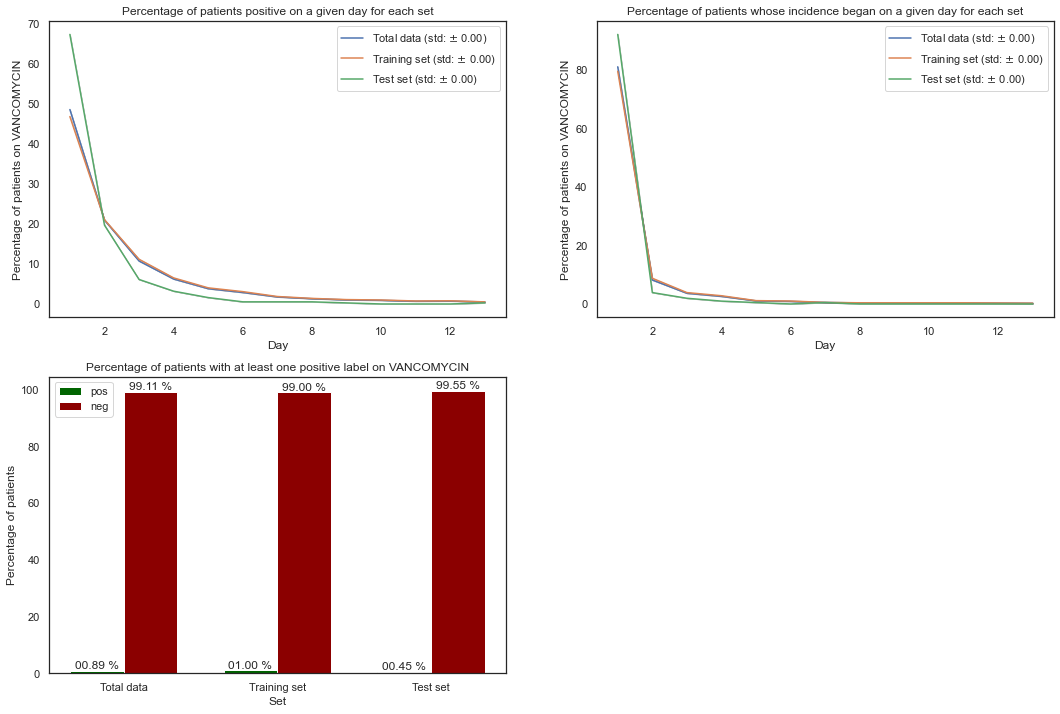

folder='./data/pickled_data_sets/mimic_4/14_ts_0'


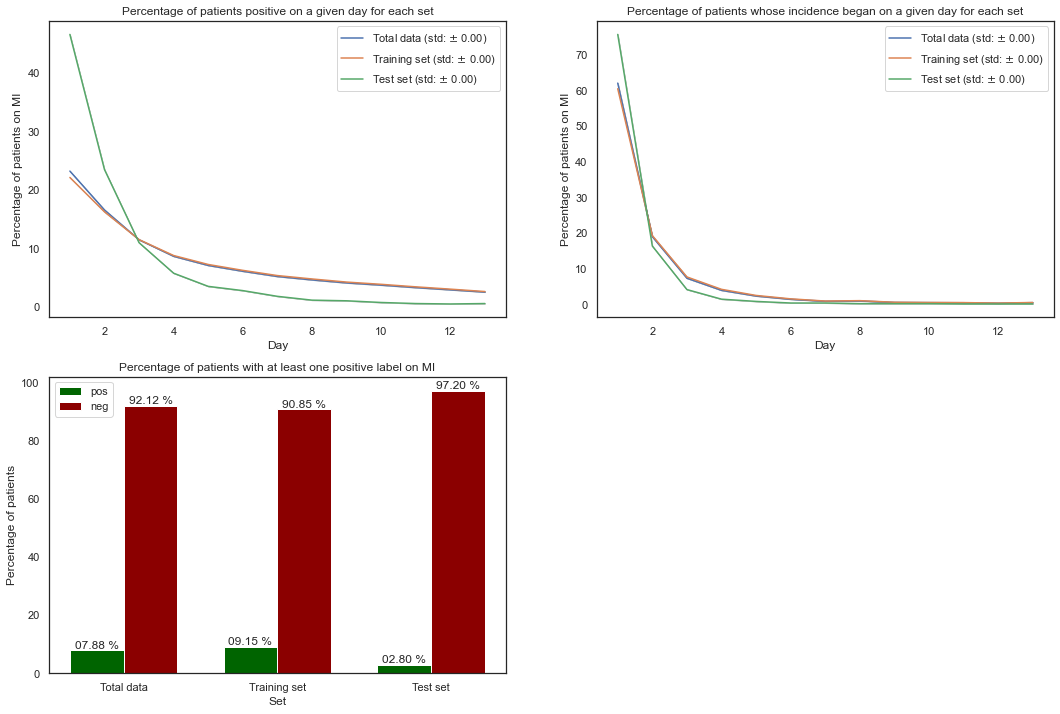

folder='./data/pickled_data_sets/mimic_4/14_ts_0'


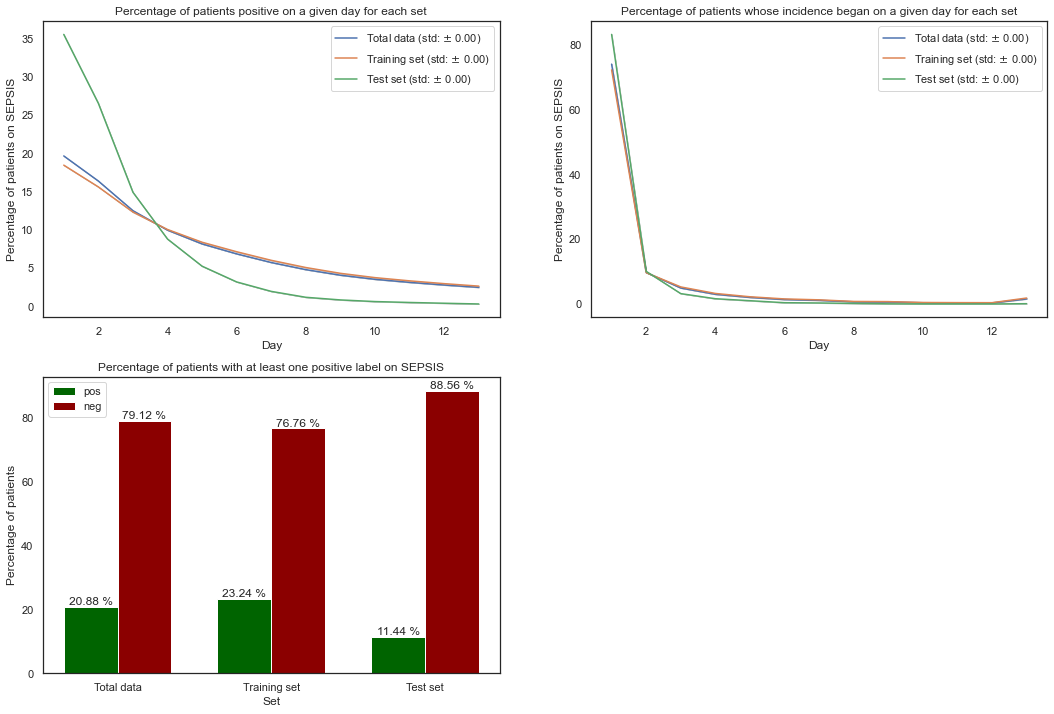

In [13]:
def plot_data_distribution(mimic_version, time_step_id, seeds, target, save_fig = True):
    labels = ["Total data", "Training set", "Test set"]
    message = "The total kurtosis of {0} is {1:.2f} with {2:.2f} % of events occuring between days 0 and 2"
    pos_dict = dict()
    total_pos_dict = dict()
    n_pos = dict()
    n_neg = dict()
    targets = get_targets()
    target_index = targets.index(target)
    
    for label in labels:
        pos_dict[label] = []
        total_pos_dict[label] = []
        n_pos[label] = []
        n_neg[label] = []
        
    for seed in seeds:
        folder = get_pickle_folder(mimic_version, time_step_id, seed)
        print(f'{folder=}')
        y_train = load_pickle_file('train_targets', targets, folder)[:,:,target_index]
        y_test = load_pickle_file('test_targets', targets, folder)[:,:,target_index]
        split_sets = [y_train, y_test]
        y_total = np.concatenate(split_sets, axis=0)
        
        n_time_steps = y_total.shape[1]
        sets = [y_total] + split_sets
        for y, label in zip(sets, labels):
            y_sum = y.sum(axis=1)
            n_positives = np.count_nonzero(y_sum)
            n_pos[label].append(n_positives)
            n_neg[label].append(len(y_sum) - n_positives)
            
            
            y_vector = np.nansum(y, axis=0).squeeze()
            # print(message.format(label, kurtosis(y_vector), 100*int(np.sum(y_vector[0:2]))/np.sum(y_vector)))
            y_vector *= 100/y_vector.sum()
            pos_dict[label].append(y_vector)
            
            pos_y_total = y[np.nansum(y.squeeze(), axis=1) == 1]
            (days_total, value_counts_total) = np.unique(np.nanargmax(pos_y_total, axis=1), return_counts=True)
            day_value_dict_total = dict(zip(np.arange(n_time_steps), np.zeros(n_time_steps)))
            for i in range(len(days_total)):
                day = days_total[i]
                day_value_dict_total[day] = value_counts_total[i]
            y_vector_total_pos = np.array(list(day_value_dict_total.values()))
            y_vector_total_pos = y_vector_total_pos * 100/y_vector_total_pos.sum()
            total_pos_dict[label].append(y_vector_total_pos)
        
    plt.figure(figsize=(18, 12))
    sns.set(style="white")
    sns.despine(left=True, bottom=True)

    ## TOTAL

    ### When do people have incidents?

    # number of people who are positive on a given day
    plt.subplot(2, 2, 1)
    plt.title('Percentage of patients positive on a given day for each set')
    plt.ylabel(f'Percentage of patients on {target}')
    plt.xlabel('Day')
    
    x = np.arange(n_time_steps) + 1
    for label in pos_dict.keys():
        mean_y = np.mean(pos_dict[label], axis=0)
        std_y = np.std(pos_dict[label], axis=0)
        upper_y = np.minimum(mean_y + std_y, 100)
        lower_y = np.maximum(mean_y - std_y, 0)
        plt.plot(x, mean_y, label=label + r' (std: $\pm$ %0.2f)' % (np.mean(std_y)))
        plt.fill_between(x, lower_y, upper_y, color='black', alpha=.2)
    plt.legend()
        
    # first incident - number of people who had their first incident on a given day
    x = np.arange(n_time_steps) + 1
    plt.subplot(2, 2 ,2)
    plt.title('Percentage of patients whose incidence began on a given day for each set')
    plt.ylabel(f'Percentage of patients on {target}')
    plt.xlabel('Day')
    for label in pos_dict.keys():
        mean_y = np.mean(total_pos_dict[label], axis=0) 
        std_y = np.std(total_pos_dict[label], axis=0)
        upper_y = np.minimum(mean_y + std_y, 100) 
        lower_y = np.maximum(mean_y - std_y, 0)
        plt.plot(x, mean_y, label=label + r' (std: $\pm$ %0.2f)' % (np.mean(std_y)))
        plt.fill_between(x, lower_y, upper_y, color='black', alpha=.2)
        
    plt.legend()

    plt.subplot(2, 2 ,3)
    plt.title(f'Percentage of patients with at least one positive label on {target}')
    plt.ylabel('Percentage of patients'.format(target))
    plt.xlabel('Set')
    y = 0
    width = 0.35
    for label in pos_dict.keys():
        n_total = (n_pos[label][0] + n_neg[label][0])/100
        mean_n_pos = np.mean(n_pos[label])/n_total 
        std_n_pos = np.std(n_pos[label])/n_total 
        mean_n_neg = np.mean(n_neg[label])/n_total 
        std_n_neg = np.std(n_neg[label])/n_total 
        container = plt.bar([y - width/2], mean_n_pos, width=width, color='darkgreen', label='pos')
        plt.bar_label(container, [r'%05.2f %%' % (mean_n_pos)])
        container = plt.bar([y + width/2], mean_n_neg, width=width, color='darkred', label='neg')
        plt.bar_label(container, [r'%05.2f %%' % (mean_n_neg)])
        if y == 0:
            plt.legend()
        y += 1
    plt.xticks(range(len(pos_dict.keys())), pos_dict.keys())
    
    
    if save_fig:
        plt.savefig(f'{figure_dir}/{target}_Set_Distributions.{figure_format}', 
                    format=figure_format, dpi=300, bbox_inches='tight')
    else:
        plt.show()

for target in targets:
    plot_data_distribution(mimic_version, time_step_id, seeds, target, False)

## Is the time component important/ is a FNN sufficient

In [7]:
def get_prediction_dict(model_dict, input_data):
    input_data = torch.tensor(input_data, dtype=torch.float).clone().detach()
    prediction_dict = dict()
    with torch.no_grad():
        for model_type in model_dict.keys():
            print(f'Creating Predictions for {model_type=}')
            prediction_dict[model_type] = []
            n_models = len(model_dict[model_type])
            for model in model_dict[model_type]:
                prediction = model(input_data)
                prediction = torch.stack(prediction, dim=2)[:,:,:,0].detach().numpy()
                prediction_dict[model_type].append(prediction)
    print(f'Number of models/predictions per model type: {len(prediction_dict[model_type])}')
    return prediction_dict

def plot_curves(predictions, plot_roc, target_dict, mask_dict, labels, save_fig=True, target_index=None):
    if plot_roc:
        method = 'ROC curve'
    else:
        method = 'Precision-Recall curve'
    
    targets = list(target_dict.values())
    masks = list(mask_dict.values())
    
    mean_x = np.linspace(0, 1, 1000)
    
    plt.figure()
    plt.axhline(0, color='black')
    plt.axvline(0, color='black')
    for model_type, label in zip(predictions.keys(), labels):
        y_value_list = []
        auc_list = []
        n_entries = len(predictions[model_type])
        for prediction, y, mask in zip(predictions[model_type], targets * n_entries, masks * n_entries):
            if target_index is not None:
                mask = mask[:,:,target_index]
                y = y[:,:,target_index]
                prediction = prediction[:,:,target_index]
            y = y[~mask]
            prediction = prediction[~mask]
            if plot_roc:
                x_values, y_values, thresholds = roc_curve(y, prediction)
            else:
                y_values, x_values, thresholds = precision_recall_curve(y,  prediction)
                y_values = y_values[::-1]
            # plt.plot(x_values, y_values)
            y_value_list.append(interp(mean_x, sorted(x_values), y_values))
            area_uc = auc(x_values, y_values)
            auc_list.append(area_uc)

        print(f'{model_type} {method} AUCs: ', end="")
        print(['{0:0.2f}'.format(auc) for auc in auc_list])
        mean_y = np.mean(y_value_list, axis=0)
        mean_auc = auc(mean_x, mean_y) 
        std_auc = np.std(auc_list) 
        plt.plot(mean_x, mean_y, lw=2, alpha=.8,
                 label=label + r' (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc * 100, std_auc * 100))

        std_y = np.std(y_value_list, axis=0)
        upper_y = np.minimum(mean_y + std_y, 1)
        lower_y = np.maximum(mean_y - std_y, 0)
        plt.fill_between(mean_x, lower_y, upper_y, color='grey', alpha=.2)

        
    target_str = get_targets()
    if target_index is not None:
        target_str = target_str[target_index]
    title = f'{method} for {target_str}'
    if plot_roc:
        xlabel = 'False Positive Rate'
        ylabel = 'True Positive Rate'
        plt.plot([0, 1], [0, 1], color='black', linestyle='--', label='Chance')
    else:
        xlabel = 'Recall'
        ylabel = 'Precision'
        chance = len(y[y==1])/len(y)
        plt.plot([0, 1], [chance, chance], linestyle='--', lw=2, color='r', label='Chance N_Positive/N_All', alpha=.8)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend(loc="best")
    if save_fig:
        plt.savefig(f'{figure_dir}/{target}_{title}.{figure_format}',
                    format=figure_format, dpi=300, facecolor='white', transparent=True, bbox_inches='tight')
    else:
        plt.show()
    
def compare_NN_RNN(model_types, plot_labels, mimic_version, target, time_step_id, seeds, n_folds, target_indeces):
    assert len(model_types) == len(plot_labels)
    
    model_dict_time = get_model_dict(model_types, mimic_version, target, time_step_id, seeds, n_folds)
    print(model_dict_time.keys())
    print_param_count(model_dict_time, False)
    
    input_data_dict = get_pickle_dict('test_data', seeds, mimic_version, target, time_step_id)
    predictions = get_prediction_dict(model_dict_time, list(input_data_dict.values())[0])
    del input_data_dict
    
    target_dict = get_pickle_dict('test_targets', seeds, mimic_version, target, time_step_id)
    mask_dict = get_pickle_dict('test_targets_mask', seeds, mimic_version, target, time_step_id)

    for target_index in target_indeces:
        plot_curves(predictions, True, target_dict, mask_dict, plot_labels, target_index=target_index)
        plot_curves(predictions, False, target_dict, mask_dict, plot_labels, target_index=target_index)

In [8]:
model_types = ['partial_attention_LSTM', 'comparison_LSTM', 'comparison_FNN']
plot_labels = ['Deepak LSTM', 'LSTM', 'NN']
#compare_NN_RNN(model_types, plot_labels, mimic_version, targets, time_step_id, seeds, n_folds, target_indices)

## Finding out which Window Size yields the best results

In [9]:
def get_model_dict_mts(time_step_ids, targets, n_folds, model_type='partial_attention_LSTM'):
    model_dict_mts = dict()

    for time_step_id in time_step_ids:
        model_dict_mts[time_step_id] = []
        for seed in seeds:
            model_name = get_model_name(model_type, mimic_version, targets, time_step_id, seed)
            model = load_model(model_name)
            model.eval()
            model_dict_mts[time_step_id].append(model)
            for fold in range(n_folds):
                model_name = get_model_name(model_type, mimic_version, targets, time_step_id, seed, fold)
                model = load_model(model_name)
                model.eval()
                model_dict_mts[time_step_id].append(model)
        print(f'Loaded {len(model_dict_mts[time_step_id])} models of {time_step_id}')
        
    return model_dict_mts

def get_prediction_dict_multiple_data(time_step_ids, model_dict, seed, mimic_version, target):
    prediction_dict = dict()
    with torch.no_grad():
        for i in range(len(model_dict.keys())):
            model_type = list(model_dict.keys())[i]
            prediction_dict[model_type] = []
            folder = get_pickle_folder(mimic_version, time_step_ids[i], seed)
            input_data = torch.tensor(load_pickle_file("test_data", target, folder), dtype=torch.float).clone().detach()    
            for model in model_dict[model_type]:
                prediction = model(input_data)
                prediction_dict[model_type].append(torch.stack(prediction, dim=2)[:,:,:,0].detach().numpy())
            
    print(f'Number of models/predictions per model type: {len(prediction_dict[model_type])}')
    return prediction_dict


def plot_curves_md(predictions, plot_roc, target_dict_list, mask_dict_list, save_fig=True, target_index=None):
    if plot_roc:
        method = 'ROC curve'
    else:
        method = 'Precision-Recall curve'
    mean_x = np.linspace(0, 1, 1000)
    
    plt.figure()
    plt.axhline(0, color='black')
    plt.axvline(0, color='black')
    for model_type, target_dict, mask_dict in zip(predictions.keys(), target_dict_list, mask_dict_list):
        y_value_list = []
        auc_list = []
        n_models = len(predictions[model_type])
        for prediction, y, mask in zip(predictions[model_type],
                                          list(target_dict.values()) * n_models, list(mask_dict.values()) * n_models):
            if target_index is not None:
                mask = mask[:,:,target_index]
                y = y[:,:,target_index]
                prediction = prediction[:,:,target_index]
            y = y[~mask]
            prediction = prediction[~mask]
            if plot_roc:
                x_values, y_values, thresholds = roc_curve(y, prediction)
            else:
                y_values, x_values, thresholds = precision_recall_curve(y,  prediction)
                y_values = y_values[::-1]
            # plt.plot(x_values, y_values)
            y_value_list.append(interp(mean_x, sorted(x_values), y_values))
            area_uc = auc(x_values, y_values)
            auc_list.append(area_uc)

        print(f'{model_type} {method} AUCs: ', end="")
        print(['{0:0.2f}'.format(auc) for auc in auc_list])
        mean_y = np.mean(y_value_list, axis=0)
        mean_auc = auc(mean_x, mean_y)
        std_auc = np.std(auc_list)
        plt.plot(mean_x, mean_y, lw=2, alpha=.8, label=str(24 * 14 // model_type)
                 + r'h per time step (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc * 100, std_auc * 100))

        std_y = np.std(y_value_list, axis=0)
        upper_y = np.minimum(mean_y + std_y, 1)
        lower_y = np.maximum(mean_y - std_y, 0)
        plt.fill_between(mean_x, lower_y, upper_y, color='grey', alpha=.2)

    target_str = get_targets()
    if target_index is not None:
        target_str = target_str[target_index]
    title = f'{method} for {target_str}'
    if plot_roc:
        xlabel = 'False Positive Rate'
        ylabel = 'True Positive Rate'
        plt.plot([0, 1], [0, 1], color='black', linestyle='--', label='Chance')
    else:
        xlabel = 'Recall'
        ylabel = 'Precision'
        chance = len(y[y==1])/len(y)
        plt.plot([0, 1], [chance, chance], linestyle='--', lw=2, color='r', label='Chance N_Positive/N_All', alpha=.8)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend(loc="best")
    if save_fig:
        plt.savefig(f'{figure_dir}/{target}_{title}.{figure_format}',
                    format=figure_format, dpi=300, facecolor='white', transparent=True, bbox_inches='tight')
    else:
        plt.show()

def compare_window_size(time_step_ids, mimic_version, target, seeds, n_folds, target_indices):
    model_dict_mts = get_model_dict_mts(time_step_ids, targets, n_folds)
    print(model_dict_mts.keys())
    print_param_count(model_dict_mts)
    
    predictions_md = get_prediction_dict_multiple_data(time_step_ids, model_dict_mts, seeds[0], mimic_version, target)

    #Plotting
    target_dict_list = []
    for time_step_id in time_step_ids:
        target_dict_list.append(get_pickle_dict("test_targets", seeds, mimic_version, target, time_step_id))
    mask_dict_list = []
    for time_step_id in time_step_ids:
        mask_dict_list.append(get_pickle_dict("test_targets_mask", seeds, mimic_version, target, time_step_id))
    for target_index in target_indices:
        plot_curves_md(predictions_md, True, target_dict_list, mask_dict_list, target_index=target_index)
        plot_curves_md(predictions_md, False, target_dict_list, mask_dict_list, target_index=target_index)

In [10]:
second_time_step_id = 28
time_step_ids = [time_step_id, second_time_step_id]
#compare_window_size(time_step_ids, mimic_version, targets, seeds, n_folds, target_indices)

Loaded 3 models of type partial_attention_LSTM
Loaded 3 models of type full_attention_LSTM
Loaded 3 models of type p_attention_LSTM
dict_keys(['partial_attention_LSTM', 'full_attention_LSTM', 'p_attention_LSTM'])
partial_attention_LSTM number of Parameters: 521427
full_attention_LSTM number of Parameters: 521427
p_attention_LSTM number of Parameters: 521427
Creating Predictions for model_type='partial_attention_LSTM'
Creating Predictions for model_type='full_attention_LSTM'
Creating Predictions for model_type='p_attention_LSTM'
Number of models/predictions per model type: 3
partial_attention_LSTM ROC curve AUCs: ['0.99', '0.99', '0.99']
full_attention_LSTM ROC curve AUCs: ['0.86', '0.88', '0.88']
p_attention_LSTM ROC curve AUCs: ['0.98', '0.98', '0.98']
partial_attention_LSTM Precision-Recall curve AUCs: ['0.03', '0.03', '0.03']
full_attention_LSTM Precision-Recall curve AUCs: ['0.00', '0.01', '0.00']
p_attention_LSTM Precision-Recall curve AUCs: ['0.03', '0.02', '0.03']
partial_attent

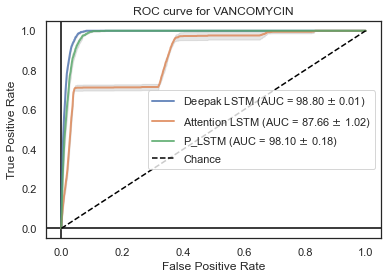

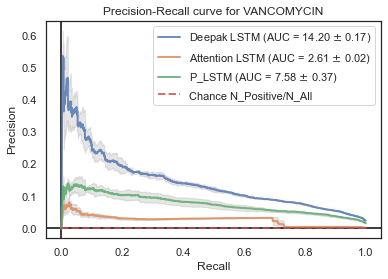

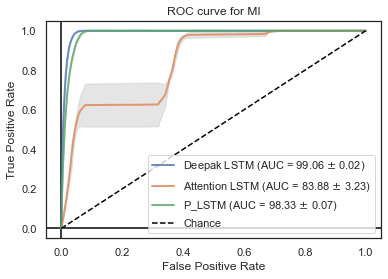

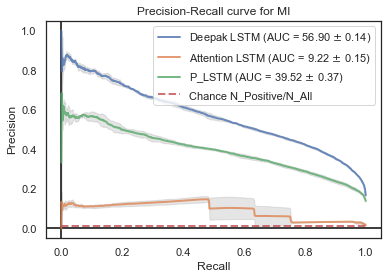

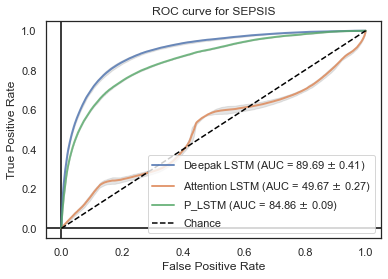

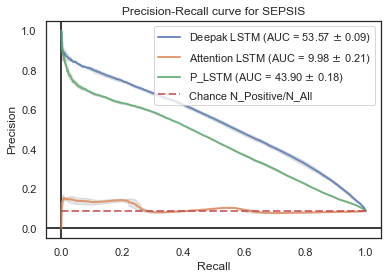

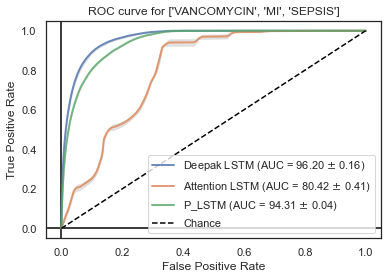

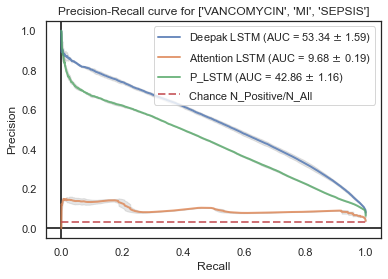

In [11]:
model_types = ['partial_attention_LSTM', 'full_attention_LSTM', 'hopfield_layer', 'hopfield_pooling',
               'partial_hopfield_LSTM', 'full_hopfield_LSTM',  'hopfield_lookup']
plot_labels = ['Deepak LSTM', 'Attention LSTM', 'Hopfield Layer', 'Hopfield Pooling',
               'Hopfield LSTM P','Hopfield LSTM F', 'Hopfield Lookup']

model_types = ['partial_attention_LSTM', 'full_attention_LSTM', 'p_attention_LSTM']
plot_labels = ['Deepak LSTM', 'Attention LSTM', 'P_LSTM']

compare_NN_RNN(model_types, plot_labels, mimic_version, targets, time_step_id, seeds, n_folds, target_indices)

Loaded 3 models of type partial_attention_LSTM
Loaded 3 models of type full_attention_LSTM
Loaded 3 models of type p_attention_LSTM
dict_keys(['partial_attention_LSTM', 'full_attention_LSTM', 'p_attention_LSTM'])
partial_attention_LSTM number of Parameters: 521427
full_attention_LSTM number of Parameters: 521427
p_attention_LSTM number of Parameters: 521427
Creating Predictions for model_type='partial_attention_LSTM'
Creating Predictions for model_type='full_attention_LSTM'
Creating Predictions for model_type='p_attention_LSTM'
Number of models/attention per model type: 3


C:\Users\moser\AppData\Local\Temp/ipykernel_11552/1058249528.py:175: RuntimeWarning: Mean of empty slice
  mean_attentions[key] = np.nanmean(stacked_attention, axis=3)


208
208
[]


C:\Users\moser\AppData\Local\Temp/ipykernel_11552/1058249528.py:120: RuntimeWarning: Mean of empty slice
  np.nanargmax(np.nanmean(activations, axis=0).T[arranged_indices], axis=0)
C:\Users\moser\AppData\Local\Temp/ipykernel_11552/1058249528.py:121: RuntimeWarning: Mean of empty slice
  print(np.array(features)[arranged_indices][np.nanargmax(np.nanmean(activations, axis=0).T[arranged_indices],


['systolic_max' 'bun_max' 'ldl' 'temperature (f)_max'
 'temperature (f)_max' 'temperature (f)_max' 'temperature (f)_max'
 'temperature (f)_max' 'temperature (f)_max' 'temperature (f)_max' 'ldl'
 'calcium gluconate' 'calcium gluconate']


C:\Users\moser\AppData\Local\Temp/ipykernel_11552/1058249528.py:128: RuntimeWarning: Mean of empty slice
  heatmap(np.nanmean(activations,axis=0).T[arranged_indices], square=False,


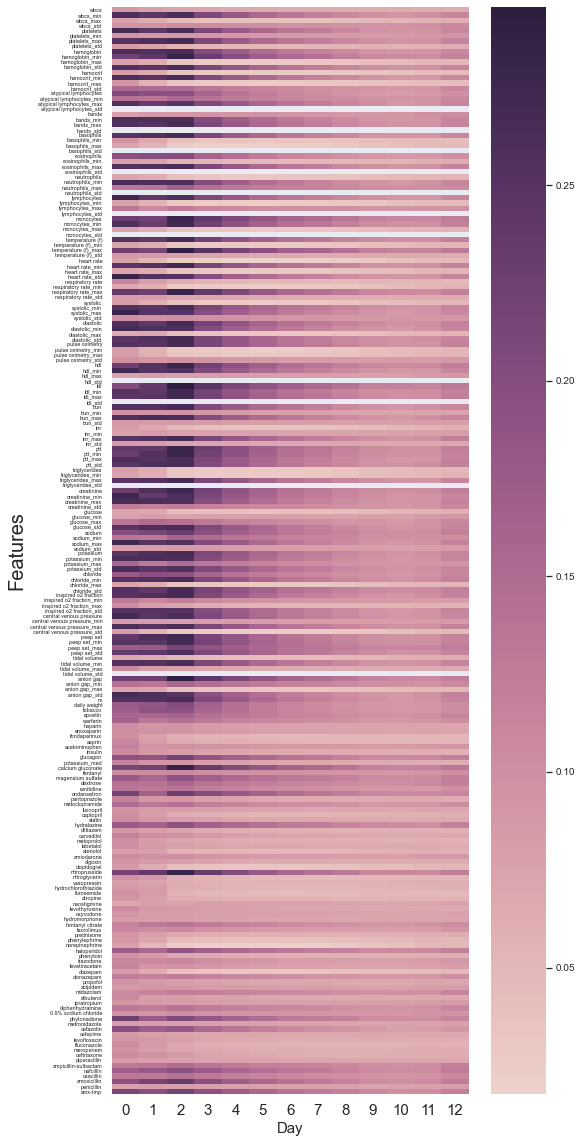

(60961, 13, 208)


C:\Users\moser\AppData\Local\Temp/ipykernel_11552/1058249528.py:139: RuntimeWarning: Mean of empty slice
  activations = np.nanmean(np.nanmean(activations, axis=2), axis=0)


[0.15483335 0.14735427 0.15055725 0.12759045 0.11425474 0.10365754
 0.09525944 0.09039481 0.08498948 0.08043195 0.07894694 0.08160213
 0.09035537]
There is a -0.04830401060949754 % change between day 0 and 1


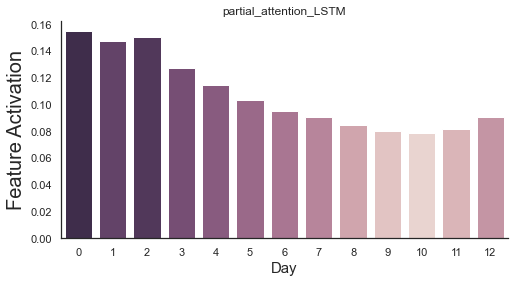

C:\Users\moser\AppData\Local\Temp/ipykernel_11552/1058249528.py:120: RuntimeWarning: Mean of empty slice
  np.nanargmax(np.nanmean(activations, axis=0).T[arranged_indices], axis=0)
C:\Users\moser\AppData\Local\Temp/ipykernel_11552/1058249528.py:121: RuntimeWarning: Mean of empty slice
  print(np.array(features)[arranged_indices][np.nanargmax(np.nanmean(activations, axis=0).T[arranged_indices],


['creatinine' 'creatinine' 'inspired o2 fraction_min'
 'inspired o2 fraction_min' 'inspired o2 fraction_min'
 'inspired o2 fraction_min' 'inspired o2 fraction_min' 'ptt_min' 'ptt_min'
 'creatinine' 'creatinine' 'creatinine' 'creatinine']


C:\Users\moser\AppData\Local\Temp/ipykernel_11552/1058249528.py:128: RuntimeWarning: Mean of empty slice
  heatmap(np.nanmean(activations,axis=0).T[arranged_indices], square=False,


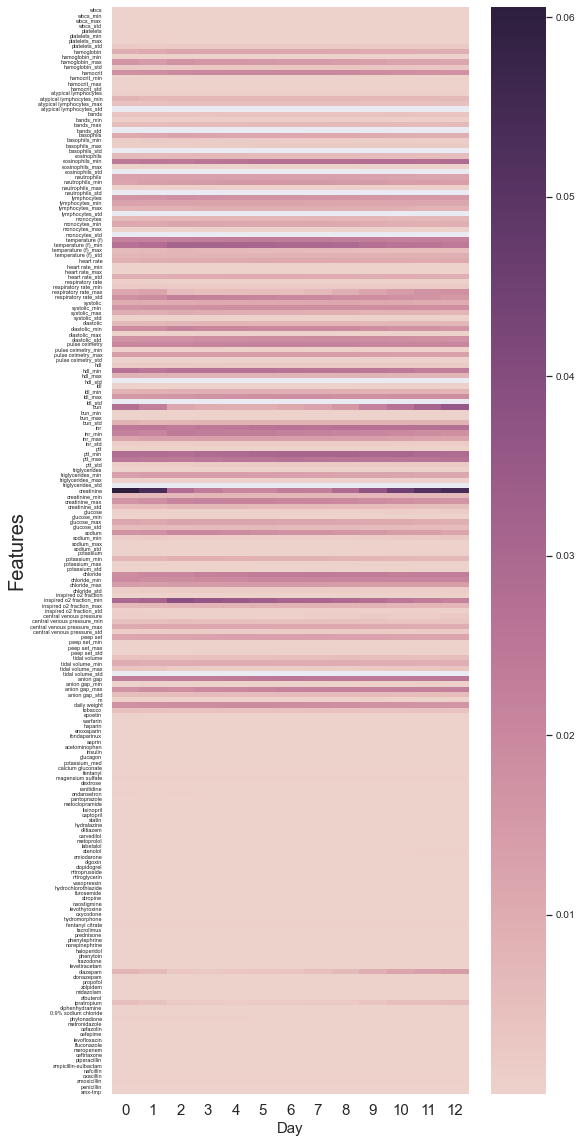

(60961, 13, 208)
[0.00507582 0.0050758  0.00507578 0.00507583 0.00507504 0.00507557
 0.00507551 0.00507555 0.00507557 0.0050756  0.00507563 0.00507564
 0.00507566]
There is a -3.027457942646002e-06 % change between day 0 and 1


C:\Users\moser\AppData\Local\Temp/ipykernel_11552/1058249528.py:141: RuntimeWarning: Mean of empty slice
  activations = np.nanmean(np.nanmean(activations, axis=2), axis=0)


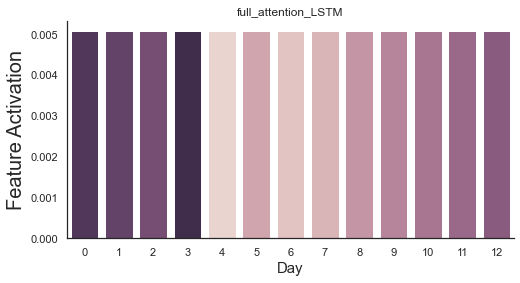

C:\Users\moser\AppData\Local\Temp/ipykernel_11552/1058249528.py:120: RuntimeWarning: Mean of empty slice
  np.nanargmax(np.nanmean(activations, axis=0).T[arranged_indices], axis=0)
C:\Users\moser\AppData\Local\Temp/ipykernel_11552/1058249528.py:121: RuntimeWarning: Mean of empty slice
  print(np.array(features)[arranged_indices][np.nanargmax(np.nanmean(activations, axis=0).T[arranged_indices],


['dextrose' 'dextrose' 'dextrose' 'dextrose' 'dextrose' 'dextrose'
 'dextrose' 'dextrose' 'dextrose' 'dextrose' 'dextrose' 'dextrose'
 'dextrose']


C:\Users\moser\AppData\Local\Temp/ipykernel_11552/1058249528.py:128: RuntimeWarning: Mean of empty slice
  heatmap(np.nanmean(activations,axis=0).T[arranged_indices], square=False,


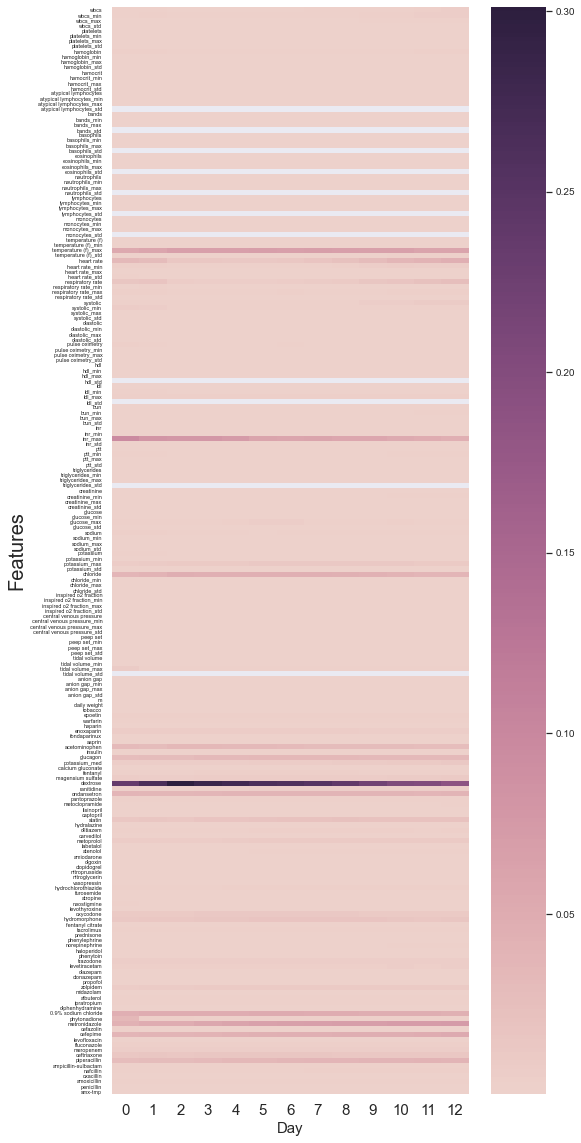

(60961, 13, 208)


C:\Users\moser\AppData\Local\Temp/ipykernel_11552/1058249528.py:141: RuntimeWarning: Mean of empty slice
  activations = np.nanmean(np.nanmean(activations, axis=2), axis=0)


[0.00507057 0.00507034 0.00507124 0.00507209 0.00507211 0.00507188
 0.00507188 0.00507169 0.00507134 0.00507106 0.00507093 0.00507055
 0.0050703 ]
There is a -4.536706316316613e-05 % change between day 0 and 1


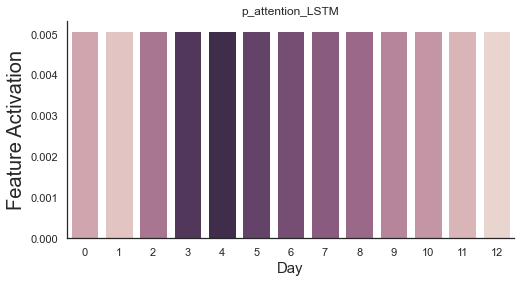

In [12]:
def get_attention_dict(model_dict, input_data, mask):
    input_data = torch.tensor(input_data, dtype=torch.float).clone().detach()
    attention_dict = dict()
    with torch.no_grad():
        for model_type in model_dict.keys():
            print(f'Creating Predictions for {model_type=}')
            attention_dict[model_type] = []
            n_models = len(model_dict[model_type])
            for model in model_dict[model_type]:
                model(input_data)
                attention = model.attention
                attention[mask] = np.nan
                attention_dict[model_type].append(attention)
    print(f'Number of models/attention per model type: {len(attention_dict[model_type])}')
    return attention_dict

def prep_features(targets, folder):
    features = load_pickle_file('features', targets, folder)
    ''' Due to the way features are selectd from the EMR and the fact potassium can be a 
    delivered medication or a lab value, special care was taken to ensure proper representation on heatmaps '''

    if 'digoxin(?!.*fab)' in features:
        indexy = features.index('digoxin(?!.*fab)')
        features[indexy] = 'digoxin'

    if 'potassium_y' in features:
        indexy = features.index('potassium_y')
        features[indexy] = 'potassium_med'

    if 'potassium_x' in features:
        indexy = features.index('potassium_x')
        features[indexy] = 'potassium'

    if 'cipfloxacin' in features:
        indexy = features.index('cipfloxacin')
        features[indexy] = 'ciprofloxacin'

    features = [feature.lower() for feature in features]
    
    
    ## FEATURES BY CATEGORY ##

    cbc_diff_features = ['RBCs', 'WBCs', 'platelets', 'hemoglobin', 'hemocrit', 'atypical lymphocytes', 'bands',
                         'basophils', 'eosinophils', 'neutrophils', 'lymphocytes', 'monocytes',
                         'polymorphonuclear leukocytes']
    vital_features = ['temperature (F)', 'heart rate', 'respiratory rate', 'systolic', 'diastolic', 'pulse oximetry']
    lab_features = ['troponin', 'HDL', 'LDL', 'BUN', 'INR', 'PTT', 'PT', 'triglycerides', 'creatinine',
                      'glucose', 'sodium', 'potassium', 'chloride', 'bicarbonate',
                      'blood culture', 'urine culture', 'surface culture', 'sputum' + 
                      ' culture', 'wound culture', 'Inspired O2 Fraction', 'central venous pressure', 
                      'PEEP Set', 'tidal volume', 'anion gap']

    demographic_features = ['age', 'm', 'black', 'daily weight', 'tobacco', 'diabetes', 'history of CV events']

    med_features = ['epoetin', 'warfarin', 'heparin', 'enoxaparin', 'fondaparinux',
                                          'asprin', 'ketorolac', 'acetominophen', 
                                          'insulin', 'glucagon', 
                                          'potassium_med', 'calcium gluconate', 
                                          'fentanyl', 'magensium sulfate', 
                                          'D5W', 'dextrose', 
                                          'ranitidine', 'ondansetron', 'pantoprazole', 'metoclopramide', 
                                          'lisinopril', 'captopril', 'statin',  
                                          'hydralazine', 'diltiazem', 
                                          'carvedilol', 'metoprolol', 'labetalol', 'atenolol',
                                          'amiodarone', 'digoxin',
                                          'clopidogrel', 'nitroprusside', 'nitroglycerin',
                                          'vasopressin', 'hydrochlorothiazide', 'furosemide', 
                                          'atropine', 'neostigmine',
                                          'levothyroxine',
                                          'oxycodone', 'hydromorphone', 'fentanyl citrate', 
                                          'tacrolimus', 'prednisone', 
                                          'phenylephrine', 'norepinephrine',
                                          'haloperidol', 'phenytoin', 'trazodone', 'levetiracetam',
                                          'diazepam', 'clonazepam',
                                          'propofol', 'zolpidem', 'midazolam', 
                                          'albuterol', 'ipratropium', 
                                          'diphenhydramine',  
                                          '0.9% Sodium Chloride',
                                          'phytonadione', 
                                          'metronidazole', 
                                          'cefazolin', 'cefepime', 'vancomycin', 'levofloxacin',
                                          'ciprofloxacin', 'fluconazole', 
                                          'meropenem', 'ceftriaxone', 'piperacillin',
                                          'ampicillin-sulbactam', 'nafcillin', 'oxacillin',
                                          'amoxicillin', 'penicillin', 'SMX-TMP']

    cbc_diff_features = [[i.lower(), i.lower()+'_min', i.lower()+'_max', i.lower()+'_std'] for i in cbc_diff_features]
    vital_features = [[i.lower(), i.lower()+'_min', i.lower()+'_max', i.lower()+'_std'] for i in vital_features]
    lab_features = [[i.lower(), i.lower()+'_min', i.lower()+'_max', i.lower()+'_std'] for i in lab_features]
    demographic_features = [i.lower() for i in demographic_features]
    med_features = [i.lower() for i in med_features]

    cbc_diff_feature_array = np.array(cbc_diff_features).flatten()
    vital_features_array = np.array(vital_features).flatten()
    lab_features_array = np.array(lab_features).flatten()
    demographic_feature_array = np.array(demographic_features).flatten()
    med_features_array = np.array(med_features).flatten()

    features_built = np.hstack([cbc_diff_feature_array,vital_features_array,
                                lab_features_array,demographic_feature_array,med_features_array])

    features_built_reduced = [i for i in features_built if i in features]
    
    ## Identifies the index in the features list in the desired order ##
    arranged_indices = [features.index(i) for i in features_built_reduced]
    ## This is a sanity check to ensure that features_built_reduced has the same number of elements as our target ##
    print(len(features))
    print(len(features_built_reduced))
    assert len(features) == len(features_built_reduced)
    print(list(set(features) - set(features_built_reduced)))
    
    return features, arranged_indices
    
def plot_attentions(mean_attentions, targets, folder):
    features, arranged_indices = prep_features(targets, folder)
    for key in mean_attentions.keys():
        activations = mean_attentions[key]
        n_time_steps = activations.shape[1]

        np.nanargmax(np.nanmean(activations, axis=0).T[arranged_indices], axis=0)
        print(np.array(features)[arranged_indices][np.nanargmax(np.nanmean(activations, axis=0).T[arranged_indices], 
                                                     axis=0)])
        
        plt.figure(figsize = (8,20))

        sns.set(font_scale = 0.5)

        heatmap(np.nanmean(activations,axis=0).T[arranged_indices], square=False, 
                yticklabels=np.array(features)[arranged_indices], cmap=my_cmap)
        plt.gcf().axes[-1].tick_params(labelsize=10)
        plt.xticks(np.arange(n_time_steps)+0.5, np.arange(n_time_steps), fontsize=15)
        plt.xlabel('Day', fontsize=15)
        plt.ylabel('Features', fontsize=20)
        plt.show()


        print(activations.shape)
        if 'partial_attention' in key:
            activations = np.nanmean(np.nanmean(activations, axis=2), axis=0)
        else:
            activations = np.nanmean(np.nanmean(activations, axis=2), axis=0)
        print(activations)
        plt.figure(figsize = (8,4)) 
        sns.set(style="white")
        y_vector = activations
        print('There is a {0} % change between day 0 and 1'.format((y_vector[1] - y_vector[0])/float(y_vector[0])))
        color_rank = np.argsort(np.argsort(y_vector))
        plot = sns.barplot(x=list(range(len(activations))), y=activations, palette=np.array(color_list)[color_rank])
        plt.xlabel('Day', fontsize=15)
        plt.ylabel('Feature Activation', fontsize=20)
        plt.title(key)
        sns.despine()

        plt.show()
        
        
        
def compare_attentions(model_types, plot_labels, mimic_version, target, time_step_id, seeds, n_folds):
    assert len(model_types) == len(plot_labels)
    
    model_dict_time = get_model_dict(model_types, mimic_version, target, time_step_id, seeds, n_folds)
    print(model_dict_time.keys())
    print_param_count(model_dict_time, False)
    
    input_data_dict = get_pickle_dict('test_data', seeds, mimic_version, target, time_step_id)
    input_data_mask_dict = get_pickle_dict('test_data_mask', seeds, mimic_version, target, time_step_id)
    attentions = get_attention_dict(model_dict_time, list(input_data_dict.values())[0], list(input_data_mask_dict.values())[0])
    del input_data_dict
    del input_data_mask_dict
    
    mean_attentions = dict()
    for key in attentions.keys():
        attention = attentions[key]
        stacked_attention = np.stack(attention, axis=3)
        mean_attentions[key] = np.nanmean(stacked_attention, axis=3)
        
    plot_attentions(mean_attentions, target, get_pickle_folder(mimic_version, time_step_id, seeds[0]))
    
model_types = ['partial_attention_LSTM', 'full_attention_LSTM', 'p_attention_LSTM']
plot_labels = ['Deepak LSTM', 'Attention LSTM', 'P_LSTM']

compare_attentions(model_types, plot_labels, mimic_version, targets, time_step_id, seeds, n_folds)